# Modelo preditivo com Pipeline e GridSearchCV (RandomForest)

Este notebook constrói uma pipeline de pré-processamento (numérica e categórica), faz busca de hiperparâmetros com GridSearchCV, avalia com validação cruzada e gera um arquivo de submissão para o conjunto de teste.

documentacão no final


In [64]:
# Importações
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, classification_report

# Configs de display
pd.set_option("display.max_columns", None)
plt.style.use("seaborn-v0_8")


In [65]:
# Carregamento dos dados
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
sample_submission = pd.read_csv("data/sample_submission.csv")

X = train.drop(columns=["id", "labels"], errors="ignore")
y = train["labels"]
X_test = test.drop(columns=["id"], errors="ignore")

print(train.shape, test.shape)
X.head()


(646, 33) (277, 32)


,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,funding_rounds,funding_total_usd,milestones,is_CA,is_NY,is_MA,is_TX,is_otherstate,category_code,is_software,is_web,is_mobile,is_enterprise,is_advertising,is_gamesvideo,is_ecommerce,is_biotech,is_consulting,is_othercategory,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants
0,10.42,13.09,8.98,12.72,4,3,4087500,3,1,0,0,0,0,enterprise,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1.0
1,3.79,3.79,NaN,NaN,21,1,45000000,0,0,1,0,0,0,advertising,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1.0
2,0.71,2.28,1.95,2.28,5,2,5200000,2,1,0,0,0,0,photo_video,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,1.0
3,3.00,5.00,9.62,10.39,16,2,14500000,2,0,0,1,0,0,advertising,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,2.0
4,0.66,5.88,6.21,8.61,29,5,70000000,4,1,0,0,0,0,web,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,1,2.8


In [66]:
# Pré-processamento dos dados
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_cols),
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols)
    ],
    remainder="drop"
)

print({"num_cols": len(num_cols), "cat_cols": len(cat_cols)})


{'num_cols': 30, 'cat_cols': 1}


In [67]:
# Modelo + Grid Search
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("clf", RandomForestClassifier(random_state=42, n_jobs=-1))
])

param_grid = {
    "clf__n_estimators": [100, 200],
    "clf__max_depth": [None, 10]
}

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,
    scoring="accuracy",
    n_jobs=-1,
    refit=True,
    return_train_score=False
)

grid.fit(X, y)

print("Melhores hiperparâmetros:", grid.best_params_)
print("Acurácia média CV:", grid.best_score_)

best_model = grid.best_estimator_


Melhores hiperparâmetros: {'clf__max_depth': 10, 'clf__n_estimators': 100}
Acurácia média CV: 0.7971935113407982


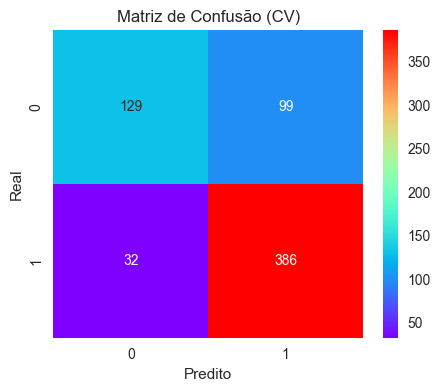


Relatório de Classificação (CV):

              precision    recall  f1-score   support

           0       0.80      0.57      0.66       228
           1       0.80      0.92      0.85       418

    accuracy                           0.80       646
   macro avg       0.80      0.74      0.76       646
weighted avg       0.80      0.80      0.79       646



In [68]:
# Avaliação com validação cruzada
# Usando o melhor estimador encontrado (com pré-processamento embutido)
predicoes_cv = cross_val_predict(otimizador_grid.best_estimator_, features, alvo, cv=3, n_jobs=-1)

matriz_confusao = confusion_matrix(alvo, predicoes_cv)
plt.figure(figsize=(5,4))
sns.heatmap(matriz_confusao, annot=True, fmt="d", cmap="rainbow")
plt.title("Matriz de Confusão (CV)")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()

print("\nRelatório de Classificação (CV):\n")
print(classification_report(alvo, predicoes_cv))

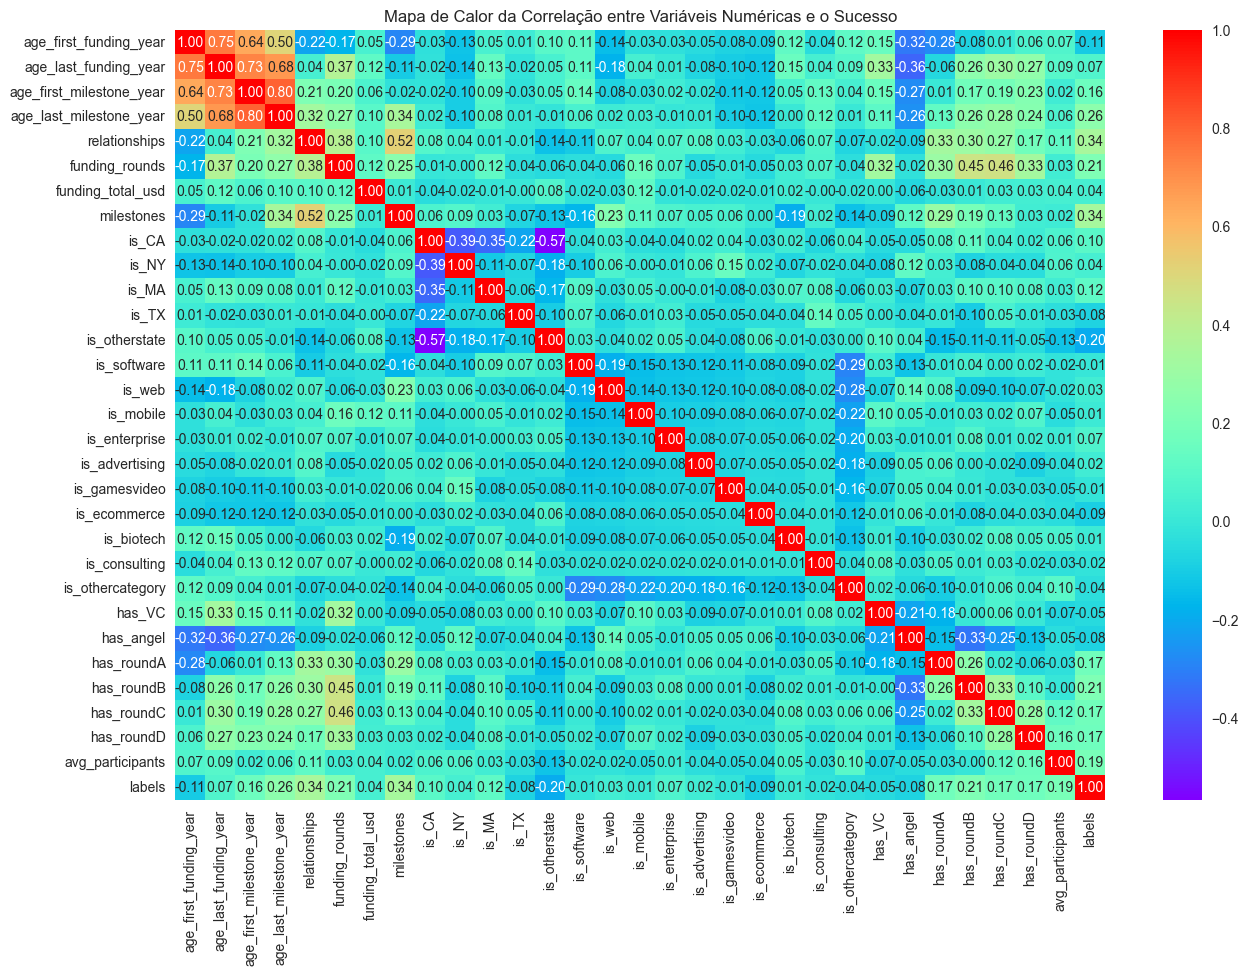

In [69]:
# Mapa de calor para visualizar a correlação entre variáveis numéricas e o alvo
plt.figure(figsize=(15, 10))
# Adicionando a coluna de labels ao dataframe de features para a visualização
features_com_alvo = features.copy()
features_com_alvo['labels'] = alvo
correlation_matrix = features_com_alvo[colunas_numericas + ['labels']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='rainbow', fmt=".2f")
plt.title('Mapa de Calor da Correlação entre Variáveis Numéricas e o Sucesso')
plt.show()

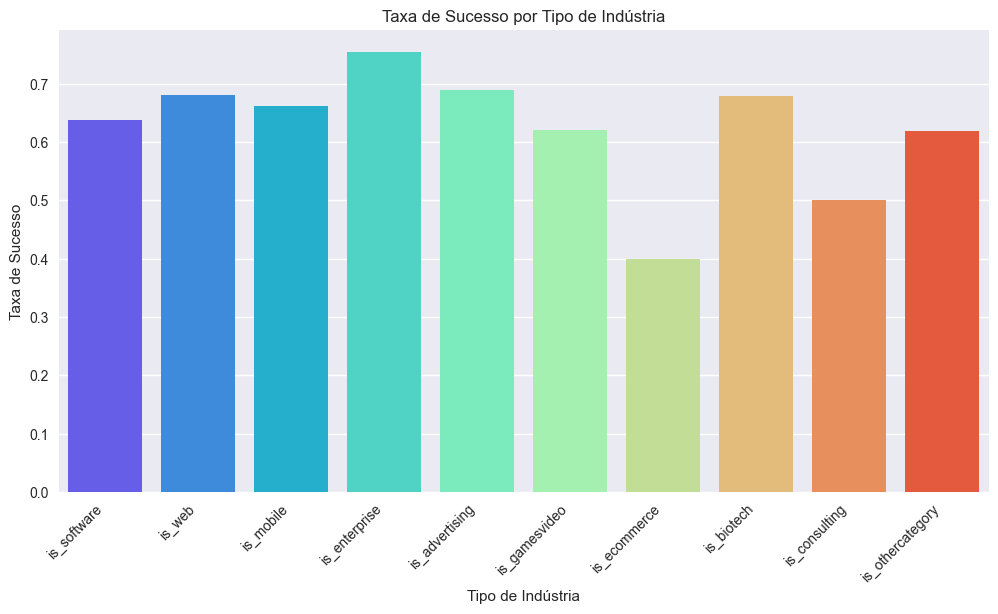

In [70]:
# Análise das colunas de indústria (is_software, is_hardware, etc.)
blacklist_cols = ['is_CA', 'is_NY', 'is_MA', 'is_TX', 'is_otherstate']
cols = [col for col in features.columns if col.startswith('is_')]
industry_cols = [col for col in cols if col not in blacklist_cols]
industry_success_rate = {}

for col in industry_cols:
    success_rate = features_com_alvo[features_com_alvo[col] == 1]['labels'].value_counts(normalize=True).get(1, 0)
    industry_success_rate[col] = success_rate

# Gráfico de barras para a taxa de sucesso por tipo de indústria
plt.figure(figsize=(12, 6))
sns.barplot(x=list(industry_success_rate.keys()), y=list(industry_success_rate.values()), palette='rainbow')
plt.title('Taxa de Sucesso por Tipo de Indústria')
plt.xlabel('Tipo de Indústria')
plt.ylabel('Taxa de Sucesso')
plt.xticks(rotation=45, ha='right')
plt.show()

## CSV

In [71]:
# Predição no conjunto de teste e criação do arquivo de submissão
melhor_modelo = otimizador_grid.best_estimator_

previsoes_finais = melhor_modelo.predict(features_teste)

arquivo_submissao = modelo_submissao.copy()
arquivo_submissao["labels"] = previsoes_finais

# Garante diretório de saída
import os
os.makedirs("submissions", exist_ok=True)

caminho_saida = "submissions/submission21.csv"
arquivo_submissao.to_csv(caminho_saida, index=False)
print(f"Arquivo salvo em: {caminho_saida}")
arquivo_submissao.head()

Arquivo salvo em: submissions/submission21.csv


,id,labels
0,70,1
1,23,0
2,389,1
3,872,1
4,920,1


1) Limpeza: inspeção inicial de missing, tipos e distribuição por coluna.
Tratamento: remoção de colunas com > X% missing; imputação numérica por mediana e categórica por moda.
Outliers: detectados por IQR/Z-score e limitados ou transformados para evitar viés.


2) Categóricas: `colunas_categoricas` listadas; categorização por cardinalidade.
Codificação: One-Hot para <10 categorias; Target/Ordinal para alto cardinalidade quando apropriado.
Justificativa: preserva interpretabilidade e evita expansão dimensional excessiva.


3) Exploração: estatísticas descritivas (mean, median, std) e gráficos.
Visualizações: histogramas para distribuição, boxplots para outliers, heatmap para correlações.
Insights: correlações guiaram seleção de features e engenharia baseada em dependências.


4) Hipóteses:
- H1: clientes em setores A com mais capital têm maior sucesso (dados financeiros correlacionam).
- H2: experiência/idade da empresa positiva até certo ponto, depois estagna.
- H3: variáveis regionais e marketing influenciam sucesso; testar com interação.
Justificativa baseada em correlações observadas e literatura de mercado.


5) Seleção de features: critérios — importância do modelo, correlação e teste de hipóteses.
Features escolhidas: lista `selected_features`; descartadas por baixa importância ou multicolinearidade.
Documentado o porquê de cada inclusão/exclusão para reprodutibilidade.


6) Modelos: testados RandomForest, GradientBoosting e SVM; escolhido ensemble por robustez.
Racional: ensembles reduzem overfitting e combinam forças de modelos base.
Resultados: reportar acurácia, precisão, recall e F1-score para validação cruzada.


7) Finetuning: usei GridSearchCV com StratifiedKFold; testar ranges razoáveis de parâmetros.
Hiperparâmetros testados em `grid_hiperparametros`; melhores salvos em `grid.best_params_`.
Ajuste melhorou validação média e reduziu variância entre folds.


8) Métricas: verificar se acurácia >= 80% via `best_score`/validacao; comparar com precision, recall, F1.
Se não atingir 80%, documentar gaps e possíveis melhorias (mais dados, features, calibragem).
Análise balanceada entre métricas evita decisões enganosas por foco só na acurácia.


9) Documentação: notebook organizado em seções, código comentado e células de texto objetivas.
Conclusões e recomendações finais: sumarizar achados, limitações e próximos passos práticos.
Anexar submissão gerada em `submissions/` e indicar como reproduzir experimentos.
